# Introduction



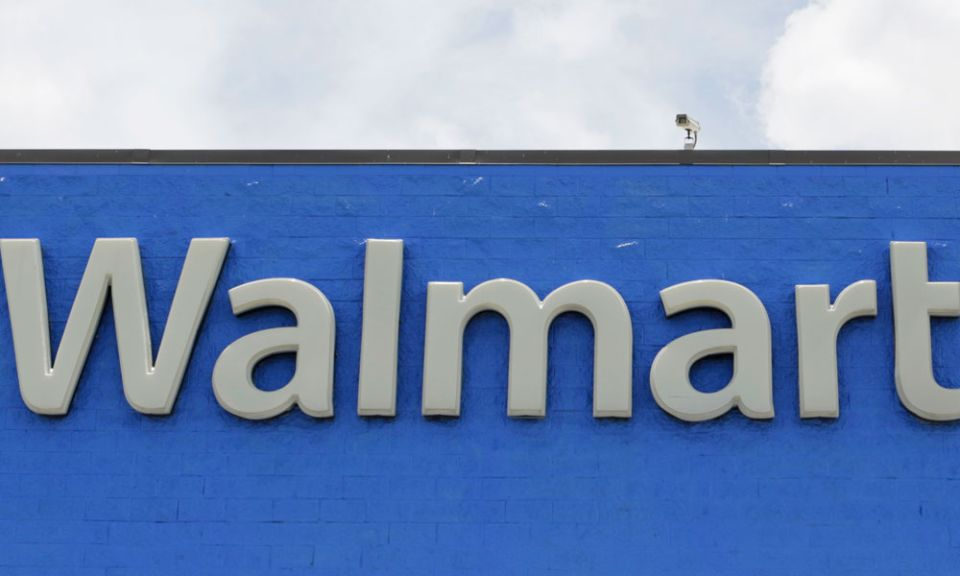

Special Thanks to all Great Kernel notebooks Author from where I got this knowledge and combine into this notebook.

<b>The dataset consists of five .csv files.</b>
<ul>
<li>calendar.csv - Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.</li>

<li>sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913].</li>

<li>submission.csv - Demonstrates the correct format for submission to the competition.</li>

<li>sell_prices.csv - Contains information about the price of the products sold per store and date.</li>

<li>sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales for [d_1 - d_1941].</li>
</ul>
In this competition, we need to forecast the sales for [d_1942 - d_1969]. These rows form the evaluation set. The rows [d_1914 - d_1941] form the validation set, and the remaining rows form the training set. Now, since we understand the dataset and know what to predict, let us visualize the dataset.

Import required  modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from fbprophet import Prophet
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import lightgbm as lgb
import dask_xgboost as xgb
import dask.dataframe as dd
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
import gc
import os
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [ ]:
!ls -GFlash --color ../input/m5-forecasting-accuracy/

# What exactly are we trying to predict?
We are trying for forecast sales for 28 forecast days. The sample submission has the following format:

The columns represent 28 forecast days. We will fill these forecast days with our predictions.
The rows each represent a specific item. This id tells us the item type, state, and store. We don't know what these items are exactly.

In [ ]:
# Read in the data
INPUT_DIR = '../input/m5-forecasting-accuracy'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

In [ ]:
ss.head()

In [ ]:
stv.head()

In [ ]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [ ]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

# Calender Visualization

In [ ]:
for i, var in enumerate(["year", "weekday", "month", "event_name_1", "event_name_2", 
                         "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]):
    plt.figure()
    g = sns.countplot(cal[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [ ]:
cal.head()

# Merging the data with real dates
We are given a calendar with additional information about past and future dates.
The calendar data can be merged with our days data
From this we can find weekly and annual trends

In [ ]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Select more top selling examples
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(cal, how='left', validate='1:1')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(cal, how='left', validate='1:1')


# Sales Counts

In [ ]:
for i, var in enumerate(["state_id", "store_id", "cat_id", "dept_id"]):
    plt.figure()
    g = sns.countplot(stv[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

# Sales broken down by time variables
Now that we have our example item lets see how it sells by:
Day of the week
Month
Year


In [ ]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()


# Lets look at a lot of different items!
Lets put it all together to plot 20 different items and their sales
Some observations from these plots:
It is common to see an item unavailable for a period of time.
Some items only sell 1 or less in a day, making it very hard to predict.
Other items show spikes in their demand (super bowl sunday?) possibly the "events" provided to us could help with these

In [ ]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [ ]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()


# Combined Sales over Time by Type
We have several item types:
Hobbies
Household
Foods
Lets plot the total demand over time for each type

In [ ]:
stv['cat_id'].unique()


In [ ]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

In [ ]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

# Rollout of items being sold.
We can see the some items come into supply that previously didn't exist. Similarly some items stop being sold completely.
Lets plot the sales, but only count if item is selling or not selling (0 -> not selling, >0 -> selling)
This plot shows us that many items are being slowly introduced into inventory, so many of them will not register a sale at the beginning of the provided data.

In [ ]:
past_sales_clipped = past_sales.clip(0, 1)
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(stv['cat_id'].unique())
plt.show()


# Sales by Store
We are provided data for 10 unique stores. What are the total sales by stores?

Note that some stores are more steady than others.
CA_2 seems to have a big change occur in 2015

In [ ]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Looking at the same data a different way, we can plot a rolling 7 day total demand count by store. Note clearly that some stores have abrupt changes in their demand, it could be that the store expanded or a new competitor was built near by. Either way this is imporant to note when creating predictive models about demand pattern.

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

# Please Upvote the Kernel , If you like this...

* **future versions coming with facebook prophet. **

Thanks..